RNNs and LSTMs are great for time-series due to the temporal bias incorporated into them. The incorporation of hidden unit allows information to persist over time and the memory cell of LSTM further ensures that long-term information (trends) are accounted for.

# Helper Functions & Loss functions  

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color='red', label='Real Demand')
    plt.plot(predicted, color='green', label='Predicted Demand')
    plt.title('Demand Prediction')
    plt.xlabel('Time')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()


In [ ]:
# Implementing Mape
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# Implementing RMSE

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse

# Implementing Peak Load

def peak_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_load_true = np.max(y_true)
    plape = np.abs((peak_load_true - np.max(y_pred)) / peak_load_true) * 100
    return plape

# Implementing Valey load
def value_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_min_true = np.min(y_true)
    vlape = np.abs((peak_min_true - np.min(y_pred)) / peak_min_true) * 100
    return vlape


# Implementing Energy absolute percent error
def energy_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total_energy_true = np.sum(y_true)
    total_energy_pred = np.sum(y_pred)
    eape = np.abs((total_energy_true - total_energy_pred) / total_energy_true) * 100

    return eape

# Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/My Drive/Datasets/Panama_Dataset/train_dataframes.xlsx"
test_path = "/content/drive/My Drive/Datasets/Panama_Dataset/test_dataframes.xlsx"

In [ ]:
train_dict = pd.read_excel(open(train_path, 'rb'), sheet_name=None, index_col=0)
test_dict = pd.read_excel(open(test_path, 'rb'), sheet_name=None, index_col=0)

# RNN for a single test-train split

In [ ]:

keys = list(train_dict.keys())
print(keys)
train = train_dict[keys[0]]
test = test_dict[keys[0]]

#print(train.head(5))
#print(len(train)) #we should obtain 36721
#print(len(test)) # we should obtain 168

['Week 15, Apr 2019', 'Week 21, May 2019', 'Week 24, Jun 2019', 'Week 29, Jul 2019', 'Week 33, Aug 2019', 'Week 37, Sep 2019', 'Week 41, Oct 2019', 'Week 44, Nov 2019', 'Week 51, Dec 2019', 'Week 01, Jan 2020', 'Week 06, Feb 2020', 'Week 10, Mar 2020', 'Week 20, May 2020', 'Week 24, Jun 2020']


We normalize our data to ensure that we don't run into **exploding gradient** problem. Normalization ensures that backpropagation remains stable

In [ ]:
data = train[['DEMAND']].values.flatten()  # Ensure it's a 1D array
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
print(len(data_scaled))  # Should be 36721

test_data = test['DEMAND'].values.flatten()
test_data_scaled = scaler.fit_transform(test_data.reshape(-1, 1)).flatten()
print(len(test_data_scaled))

36720
168


We now define *sequence_length*. We slide a window of **n_step** and assign the the **n_step + 1** as the target. Thus, our input data is $X_{t}= [x_{t-n_{step}}\dots x_{t-1},x_{t}]$ and predict $y = x_{t+1}$.

For our case, we can choose **n_step** to be 100 (use a week's data as sequence) and predict the next hour's demand. This creates 36553 sequences of length 100.

We also create a sequence for test-data. However, since we only have 168 data values, a sequence of length of say, 100, would mean that we are predicting only on the last 68 hours. Therefore, we create another function that slides a window from X_train to create 168 sequences.

We can also make the model train autoregressively on its own prediction. But it ends up outputting a sinusodial structure that is very far off from actual values (probably because errors accumulate).


In [ ]:

sequence_length = 100 #sequence length (7 days * 24 hours)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(data_scaled, sequence_length)


In [ ]:
def create_test_sequences(train_data, test_data, seq_length):

    X_test, y_test = [], []
    extended_test_data = np.concatenate((train_data[-seq_length:], test_data))  # Extend with last training sequence

    for i in range(len(test_data)):  # Ensure all 168 values are predicted
        X_test.append(extended_test_data[i:i + seq_length])
        y_test.append(extended_test_data[i + seq_length])

    return np.array(X_test), np.array(y_test)

X_test, y_test = create_test_sequences(data_scaled, test_data_scaled, sequence_length)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(36620, 100)
(36620,)
(168, 100)


In [ ]:
# To input into the RNN, we need to reshape in format (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)


(36620, 100, 1)


The input sequence $X$ consists of 168 past time steps, each with one feature $X \in \mathbb{R}^{168 \times 1}$. At each time step $t$, the input value is $x_t \in \mathbb{R}^{1}$. The RNN maintains a hidden state \( h_t \) of dimension 50. The update equation is:

$$
h_t = \sigma(W_h h_{t-1} + W_x x_t + b)
$$

where $h_t \in \mathbb{R}^{50}$ (hidden state at time \( t \)), $ W_h \in \mathbb{R}^{50 \times 50}$, $W_x \in \mathbb{R}^{50 \times 1}$ (input weight matrix), $b \in \mathbb{R}^{50}$

Only the final hidden state is passed to the Dense layers:

$$
h_{168} \in \mathbb{R}^{50}
$$

This vector is fed into a Dense layer:

$$
z = \sigma(W_h' h_{168} + b')
$$

A second Dense layer maps $z$ to the final prediction:

$$
\hat{y} = W_y z + b_y
$$



### Training the Model

In [ ]:


model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.0171 - val_loss: 0.0056
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 4.2718e-04 - val_loss: 0.0045
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - loss: 2.8861e-04 - val_loss: 0.0049


### Predicting at t + 1 time in future

We use the last 168 values from train as the initial input We iteratively predict one step ahead and append the predicted value back.
We Continue until we generate 168 future predictions



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


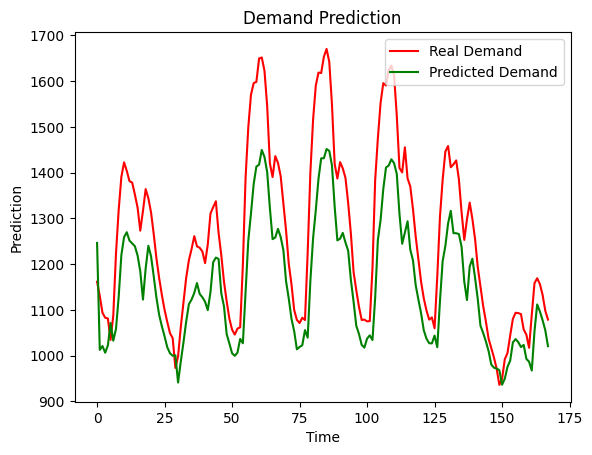

In [ ]:
predicted_rnn = model.predict(X_test)
predicted_rnn = sc.inverse_transform(predicted_rnn)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
plot_predictions(y_test_actual, predicted_rnn)


In [ ]:
print(mean_absolute_percentage_error(y_test_actual, predicted_rnn))
print(root_mean_squared_error(y_test_actual, predicted_rnn))

8.36
128.2187669123347


Let us try different model parameters:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0238 - val_loss: 0.0054
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 5.9328e-04 - val_loss: 0.0048
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 3.3587e-04 - val_loss: 0.0053
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


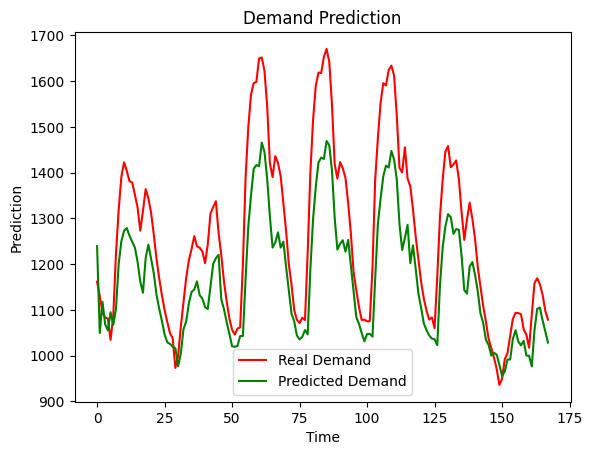

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - loss: 0.0128 - val_loss: 0.0063
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - loss: 3.5224e-04 - val_loss: 0.0047
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 2.8337e-04 - val_loss: 0.0043
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


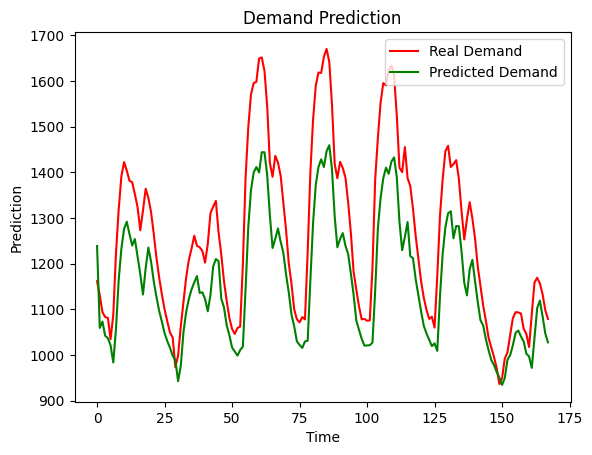

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 0.0170 - val_loss: 0.0098
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 45s 31ms/step - loss: 0.0034 - val_loss: 0.0402
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0011 - val_loss: 0.0298
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


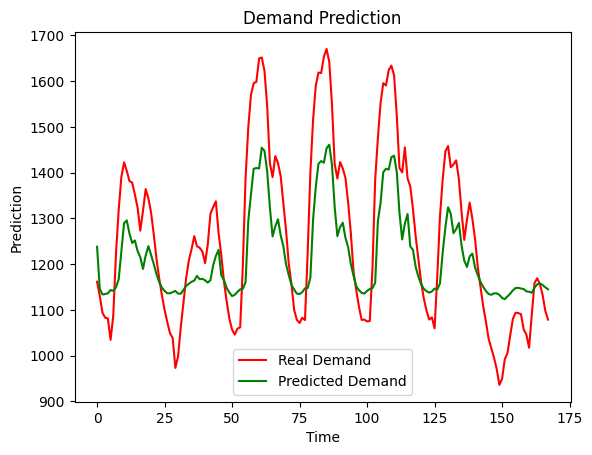

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0566 - val_loss: 0.0078
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - loss: 0.0119 - val_loss: 0.0169
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - loss: 0.0046 - val_loss: 0.0279
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


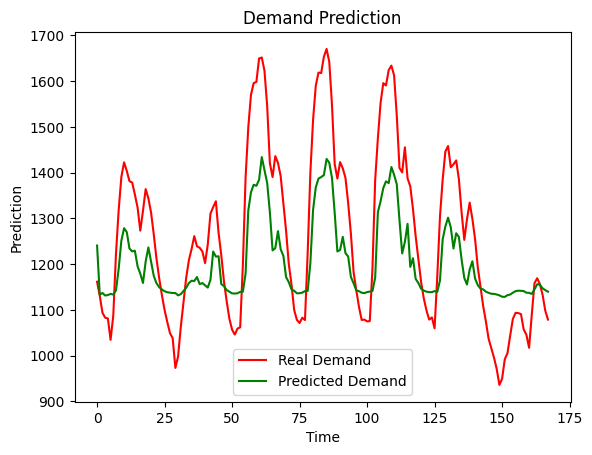

In [ ]:

model_configs = [
    {"rnn_units": 50, "dense_units": [25], "dropout": 0.0, "lr": 0.001, "label": "RNN(50) Dense(25)"},
    {"rnn_units": 100, "dense_units": [50, 25], "dropout": 0.0, "lr": 0.001, "label": "RNN(100) Dense(50,25)"},
    {"rnn_units": 100, "dense_units": [50, 25], "dropout": 0.2, "lr": 0.001, "label": "RNN(100) Dense(50,25) Dropout(0.2)"},
    {"rnn_units": 150, "dense_units": [75, 50, 25], "dropout": 0.3, "lr": 0.0005, "label": "RNN(150) Dense(75,50,25) Dropout(0.3)"},
]

predictions_dict = {}

for config in model_configs:
    model = Sequential()  # Build model
    model.add(SimpleRNN(config["rnn_units"], activation='relu', return_sequences=False, input_shape=(168, 1)))

    for units in config["dense_units"]:
        model.add(Dense(units, activation='relu'))

    if config["dropout"] > 0:
        model.add(Dropout(config["dropout"]))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=config["lr"]), loss='mse')
    model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    predicted_rnn = model.predict(X_test)
    predicted_rnn = sc.inverse_transform(predicted_rnn)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    plot_predictions(y_test_actual, predicted_rnn)



### Predicting after differencing

We see that predicting after differencing gives the best result for our RNNs.

In [ ]:
def difference_series(data):
    return np.diff(data, n=1)  # First difference

data = train[['DEMAND']].values.flatten()
test_data = test['DEMAND'].values.flatten()

data_diff = difference_series(data)
test_data_diff = difference_series(test_data)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_diff.reshape(-1, 1)).flatten()
test_data_scaled = scaler.transform(test_data_diff.reshape(-1, 1)).flatten()


In [ ]:

X_train, y_train = create_sequences(data_scaled, sequence_length)
X_test, y_test = create_test_sequences(data_scaled, test_data_scaled, sequence_length)


In [ ]:

model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - loss: 0.0084 - val_loss: 6.2463e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 6.9820e-04 - val_loss: 4.6292e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 4.0839e-04 - val_loss: 2.9994e-04


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


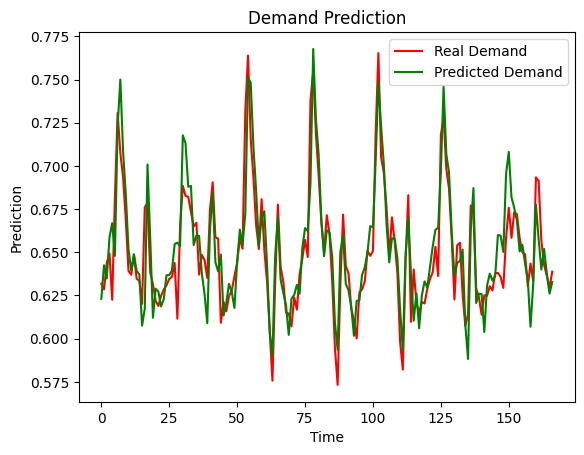

In [ ]:
predicted_rnn = model.predict(X_test)
plot_predictions(y_test, predicted_rnn)


In [ ]:
mse_AR = mean_squared_error(y_test, predicted_rnn)
mape_score = mean_absolute_percentage_error(y_test, predicted_rnn)
rmse_score = root_mean_squared_error(y_test, predicted_rnn)
plape_score = peak_load_absolute_percentage_error(y_test, predicted_rnn)
vlape_score = value_load_absolute_percentage_error(y_test, predicted_rnn)
eape_score = energy_absolute_percentage_error(y_test, predicted_rnn)

print("Metrics for Original Data:")
print('Mean Squared Error (MSE):', mse_AR)
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)


Metrics for Original Data:
Mean Squared Error (MSE): 0.0002999370714803237
MAPE:  5.69
RMSE: 0.048634275648443644
PLAPE: 0.31531320418043796
VLAPE: 2.624907236912943
EAPE: 0.3622230506821355


# RNN for Entire Train-Test split

In [ ]:
mse_MA = []
mape_MA = []
rmse_MA = []
plape_MA = []
vlape_MA = []
eape_MA = []

for i in range(len(keys)):
  data = train[['DEMAND']].values.flatten()
  test_data = test['DEMAND'].values.flatten()

  data_diff = difference_series(data)
  test_data_diff = difference_series(test_data)

  scaler = MinMaxScaler(feature_range=(0, 1))
  data_scaled = scaler.fit_transform(data_diff.reshape(-1, 1)).flatten()
  test_data_scaled = scaler.transform(test_data_diff.reshape(-1, 1)).flatten()
  X_train, y_train = create_sequences(data_scaled, sequence_length)
  X_test, y_test = create_test_sequences(data_scaled, test_data_scaled, sequence_length)

  model = Sequential([
      SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(sequence_length, 1)),
      Dense(25, activation='relu'),
      Dense(1)
  ])

  model.compile(optimizer='adam', loss='mse')

  history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)
  y_pred = model.predict(X_test)
  mse_score = mean_squared_error(y_test, y_pred)
  mape_score = mean_absolute_percentage_error(y_test, y_pred)
  rmse_score = root_mean_squared_error(y_test, y_pred)
  plape_score = peak_load_absolute_percentage_error(y_test, y_pred)
  vlape_score = value_load_absolute_percentage_error(y_test, y_pred)
  eape_score = energy_absolute_percentage_error(y_test, y_pred)

  mse_MA.append(mse_score)
  mape_MA.append(mape_score)
  rmse_MA.append(rmse_score)
  plape_MA.append(plape_score)
  vlape_MA.append(vlape_score)
  eape_MA.append(eape_score)

metrics_df = pd.DataFrame({
    "MSE": mse_MA,
    "MAPE": mape_MA,
    "RMSE": rmse_MA,
    "PLAPE": plape_MA,
    "VLAPE": vlape_MA,
    "EAPE": eape_MA
})

display(metrics_df)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - loss: 0.0056 - val_loss: 4.9004e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 4.6390e-04 - val_loss: 3.0246e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - loss: 3.1870e-04 - val_loss: 3.3070e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0283 - val_loss: 7.3968e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - loss: 7.7560e-04 - val_loss: 6.6520e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - loss: 7.2996e-04 - val_loss: 5.9118e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0095 - val_loss: 6.9887e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 7.4843e-04 - val_loss: 5.0756e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 5.9058e-04 - val_loss: 7.0291e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.0106 - val_loss: 4.4558e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 5.8907e-04 - val_loss: 5.1415e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 4.8344e-04 - val_loss: 2.8737e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - loss: 0.0476 - val_loss: 7.4911e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 8.1419e-04 - val_loss: 5.9438e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 7.0355e-04 - val_loss: 5.3294e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0210 - val_loss: 6.0356e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 7.5706e-04 - val_loss: 5.9473e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 7.5627e-04 - val_loss: 8.7937e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0438 - val_loss: 6.5541e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 7.5096e-04 - val_loss: 6.0384e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 7.0090e-04 - val_loss: 5.2560e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0076 - val_loss: 7.8100e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 8.8921e-04 - val_loss: 5.5033e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 5.8453e-04 - val_loss: 4.4820e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - loss: 0.0010 - val_loss: 5.2673e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 6.4496e-04 - val_loss: 8.4170e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 5.9779e-04 - val_loss: 5.2040e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - loss: 0.0221 - val_loss: 6.6480e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 7.5606e-04 - val_loss: 5.5968e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - loss: 6.5150e-04 - val_loss: 4.3193e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.0246 - val_loss: 6.8813e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 6.9305e-04 - val_loss: 3.8210e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 4.9555e-04 - val_loss: 3.1292e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0809 - val_loss: 7.2817e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 8.2028e-04 - val_loss: 5.3305e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 5.6597e-04 - val_loss: 3.1037e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0048 - val_loss: 6.2106e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 7.5797e-04 - val_loss: 7.8276e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - loss: 6.1064e-04 - val_loss: 6.2118e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 0.0154 - val_loss: 5.8505e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 6.5657e-04 - val_loss: 4.2947e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 4.7445e-04 - val_loss: 3.2795e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


,MSE,MAPE,RMSE,PLAPE,VLAPE,EAPE
0,0.000331,5.60,0.046964,1.308538,3.532124,1.638808
1,0.000591,4.80,0.041267,5.001121,4.512004,0.013973
2,0.000703,5.43,0.045476,1.682672,4.496770,0.919229
3,0.000287,5.59,0.047483,4.282269,4.271937,0.264269
4,0.000533,5.17,0.043793,2.595124,6.490866,0.849532
5,0.000879,5.13,0.045154,6.813129,0.999091,2.625482
6,0.000526,5.19,0.043446,4.089003,4.778285,0.933784
7,0.000448,5.26,0.045354,3.308416,6.142978,0.273139
8,0.000520,4.96,0.042996,4.805705,4.499567,0.725413
9,0.000432,5.07,0.043861,4.882276,1.814313,0.711744


# LSTMs for a single train-test split

For LSTMs, we notice that we **don't need to difference the series**. This is because LSTMs have a memory cell which allows them to capture the trend well.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = train[['DEMAND']].values.flatten()
data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
test_data = test['DEMAND'].values.flatten()
test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()
sequence_length = 100
X_train, y_train = create_sequences(data_scaled, sequence_length)
X_test, y_test = create_test_sequences(data_scaled, test_data_scaled, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)




Epoch 1/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - loss: 0.0495 - val_loss: 0.0014
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 77s 44ms/step - loss: 8.5788e-04 - val_loss: 7.5736e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - loss: 7.1006e-04 - val_loss: 6.6004e-04


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


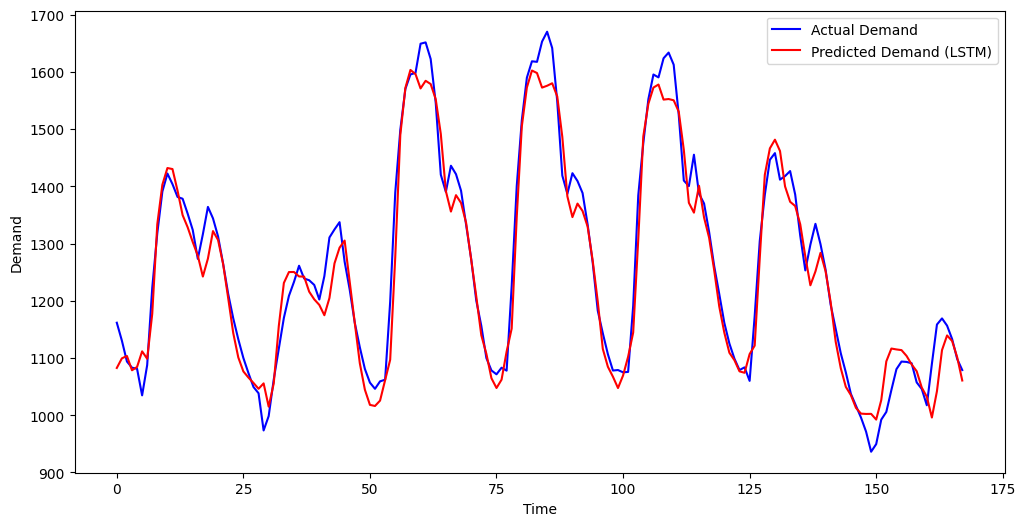

In [ ]:
predicted_lstm = model.predict(X_test)
predicted_lstm = scaler.inverse_transform(predicted_lstm)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

def plot_predictions(actual, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Demand', color='blue')
    plt.plot(predicted, label='Predicted Demand (LSTM)', color='red')
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

plot_predictions(y_test_actual, predicted_lstm)

In [ ]:
mse_AR = mean_squared_error(y_test_actual, predicted_lstm)
mape_score = mean_absolute_percentage_error(y_test_actual, predicted_lstm)
rmse_score = root_mean_squared_error(y_test_actual, predicted_lstm)
plape_score = peak_load_absolute_percentage_error(y_test_actual, predicted_lstm)
vlape_score = value_load_absolute_percentage_error(y_test_actual, predicted_lstm)
eape_score = energy_absolute_percentage_error(y_test_actual, predicted_lstm)

print("Metrics for Original Data:")
print('Mean Squared Error (MSE):', mse_AR)
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)


Metrics for Original Data:
Mean Squared Error (MSE): 1761.969425241289
MAPE:  2.48
RMSE: 41.975819530311604
PLAPE: 3.9968982000587134
VLAPE: 6.000018815714587
EAPE: 1.0329309414052763


# LSTM for entire train-test split

In [121]:
mse_MA = []
mape_MA = []
rmse_MA = []
plape_MA = []
vlape_MA = []
eape_MA = []

for i in range(len(keys)):
  data = train[['DEMAND']].values.flatten()
  test_data = test['DEMAND'].values.flatten()

  data_diff = difference_series(data)
  test_data_diff = difference_series(test_data)

  scaler = MinMaxScaler(feature_range=(0, 1))
  data_scaled = scaler.fit_transform(data_diff.reshape(-1, 1)).flatten()
  test_data_scaled = scaler.transform(test_data_diff.reshape(-1, 1)).flatten()
  X_train, y_train = create_sequences(data_scaled, sequence_length)
  X_test, y_test = create_test_sequences(data_scaled, test_data_scaled, sequence_length)

  model = Sequential([
      LSTM(50, activation='relu', return_sequences=False, input_shape=(sequence_length, 1)),
      Dense(25, activation='relu'),
      Dense(1)
  ])

  model.compile(optimizer='adam', loss='mse')

  history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)
  y_pred = model.predict(X_test)
  mse_score = mean_squared_error(y_test, y_pred)
  mape_score = mean_absolute_percentage_error(y_test, y_pred)
  rmse_score = root_mean_squared_error(y_test, y_pred)
  plape_score = peak_load_absolute_percentage_error(y_test, y_pred)
  vlape_score = value_load_absolute_percentage_error(y_test, y_pred)
  eape_score = energy_absolute_percentage_error(y_test, y_pred)

  mse_MA.append(mse_score)
  mape_MA.append(mape_score)
  rmse_MA.append(rmse_score)
  plape_MA.append(plape_score)
  vlape_MA.append(vlape_score)
  eape_MA.append(eape_score)

metrics_df = pd.DataFrame({
    "MSE": mse_MA,
    "MAPE": mape_MA,
    "RMSE": rmse_MA,
    "PLAPE": plape_MA,
    "VLAPE": vlape_MA,
    "EAPE": eape_MA
})

display(metrics_df)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - loss: 0.0253 - val_loss: 8.3653e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 76s 42ms/step - loss: 7.8679e-04 - val_loss: 7.3864e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - loss: 7.0890e-04 - val_loss: 5.4027e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - loss: 0.0220 - val_loss: 0.0011
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 0.0011 - val_loss: 8.0595e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 8.0727e-04 - val_loss: 4.9373e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 0.0224 - val_loss: 0.0012
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - loss: 0.0011 - val_loss: 9.0078e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - loss: 0.0237 - val_loss: 0.0012
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 49s 43ms/step - loss: 0.0013 - val_loss: 7.9237e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - loss: 8.2945e-04 - val_loss: 6.7178e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0331 - val_loss: 0.0011
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 0.0011 - val_loss: 7.6178e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - loss: 7.4256e-04 - val_loss: 6.2181e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0313 - val_loss: 0.0011
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - loss: 0.0012 - val_loss: 9.4968e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - loss: 0.0010 - val_loss: 7.5753e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 60s 49ms/step - loss: 0.0440 - val_loss: 8.3271e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - loss: 7.7517e-04 - val_loss: 6.5772e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - loss: 7.7180e-04 - val_loss: 6.0376e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - loss: 0.0415 - val_loss: 0.0012
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - loss: 0.0012 - val_loss: 0.0010
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - loss: 0.0227 - val_loss: 0.0011
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - loss: 0.0012 - val_loss: 9.1992e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - loss: 0.0245 - val_loss: 7.8434e-04
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - loss: 8.6438e-04 - val_loss: 6.5265e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - loss: 7.0857e-04 - val_loss: 5.5536e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - loss: 0.0345 - val_loss: 0.0011
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - loss: 0.0012 - val_loss: 9.4778e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 49s 43ms/step - loss: 0.0010 - val_loss: 6.9384e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - loss: 0.0178 - val_loss: 0.0011
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 0.0012 - val_loss: 9.2749e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - loss: 8.9310e-04 - val_loss: 7.6545e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - loss: 0.0402 - val_loss: 0.0010
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - loss: 9.2279e-04 - val_loss: 8.1175e-04
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - loss: 7.6099e-04 - val_loss: 5.7003e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - loss: 0.0514 - val_loss: 0.0012
Epoch 2/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/3
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - loss: 0.0013 - val_loss: 0.0011
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


,MSE,MAPE,RMSE,PLAPE,VLAPE,EAPE
0,0.000540,4.88,0.041867,6.024388,4.287721,0.229438
1,0.000494,5.10,0.043842,5.072225,6.850483,0.103999
2,0.000901,4.20,0.036350,10.851691,9.659521,0.144961
3,0.000672,5.18,0.043181,4.269707,4.622331,1.326806
4,0.000622,5.04,0.042462,4.158993,4.158355,0.939294
5,0.000758,4.40,0.038131,8.428912,7.075577,0.186441
6,0.000604,4.91,0.042441,5.135354,3.316347,0.396544
7,0.001040,4.20,0.035509,11.744184,11.290422,0.343880
8,0.000920,4.13,0.036219,11.435407,9.608215,0.438269
9,0.000555,4.87,0.041533,4.679610,4.568041,0.352398
